In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from ts_package.plot import plot_time_series, plot_decomposition, tsplot

In [2]:
import warnings


warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [3]:
# Старая версия расширенного датасета
# df = pd.read_csv('../data/features.csv', index_col=0)
# df['Date'] = pd.to_datetime(df['Date'])

# Новая версия расширенного датасета
df = pd.read_csv('../data/finalFeatures.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Income,Outcome,Balance,Налог на прибыль (при уплате только ежеквартальных авансовых платежей),Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца),Праздники РФ,Inflation Rate MoM: actual,Inflation Rate MoM: forecastCorrection,Balance of Trade: actual,Balance of Trade: forecastCorrection,...,Balance lag 20,Balance lag 21,Balance lag 22,Balance lag 23,Balance lag 24,Balance lag 25,Balance lag 26,Balance lag 27,Balance lag 28,Balance lag 29
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.340000,1.490000,-0.155904,0.0,0.600000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1.068610,1.194182,-0.125572,0.0,0.666667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,0.944429,0.936663,0.007767,0.0,0.733333,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,1.670000,0.875379,0.800391,0.0,0.800000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.955924,0.975645,-0.019721,0.0,0.866667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns.tolist()

['Income',
 'Outcome',
 'Balance',
 'Налог на прибыль (при уплате только ежеквартальных авансовых платежей)',
 'Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)',
 'Праздники РФ',
 'Inflation Rate MoM: actual',
 'Inflation Rate MoM: forecastCorrection',
 'Balance of Trade: actual',
 'Balance of Trade: forecastCorrection',
 'Foreign Exchange Reserves: actual',
 'Foreign Exchange Reserves: forecastCorrection',
 'Industrial Production YoY: actual',
 'Industrial Production YoY: forecastCorrection',
 'Unemployment Rate: actual',
 'Unemployment Rate: forecastCorrection',
 'Real Wage Growth YoY: actual',
 'Real Wage Growth YoY: forecastCorrection',
 'PPI MoM: actual',
 'PPI MoM: forecastCorrection',
 'Retail Sales YoY: actual',
 'Retail Sales YoY: forecastCorrection',
 'Corporate Profits: actual',
 'Corporate Profits: forecastCorrection',
 'Markit Manufacturing PMI: actual',
 'Markit Manufacturing PMI: forecastCorrection',
 'Markit Services PMI: actual',
 'Markit Services PMI: fore

In [5]:
# Типы данных собранных признаков и количество пропущенных значений в столбцах признаков
print('Dtypes:', df.dtypes, sep='\n', end='\n\n')
print('NANs:', df.isna().sum(), sep='\n')

Dtypes:
Income                                                                    float64
Outcome                                                                   float64
Balance                                                                   float64
Налог на прибыль (при уплате только ежеквартальных авансовых платежей)    float64
Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)               float64
                                                                           ...   
Balance lag 25                                                            float64
Balance lag 26                                                            float64
Balance lag 27                                                            float64
Balance lag 28                                                            float64
Balance lag 29                                                            float64
Length: 66, dtype: object

NANs:
Income                                                   

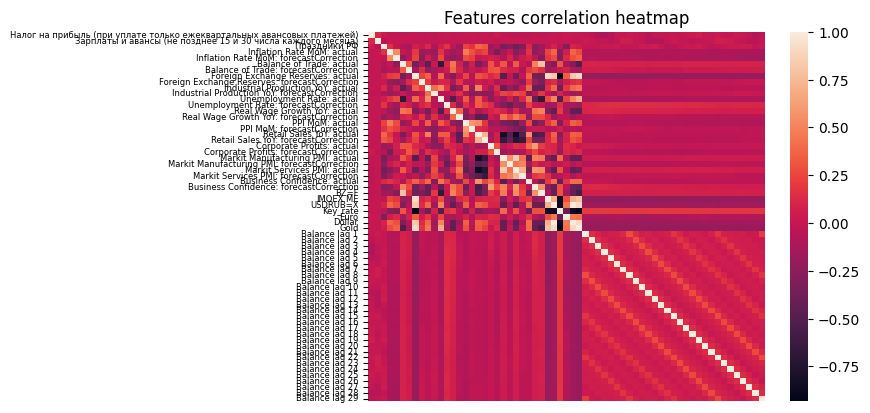

In [6]:
# Тепловая карта корреляции Пирсона между признаками
sns.heatmap(
    df.drop(['Balance', 'Income', 'Outcome'], axis=1).corr(),
    yticklabels=df.drop(['Balance', 'Income', 'Outcome'], axis=1).columns,
    xticklabels=False
)
plt.yticks(fontsize=6)
plt.title('Features correlation heatmap');

- Большая часть признаков не коррелирует сильно.
- Сильнокоррелированные признаки должны быть отфильтрованы при отборе признаков.

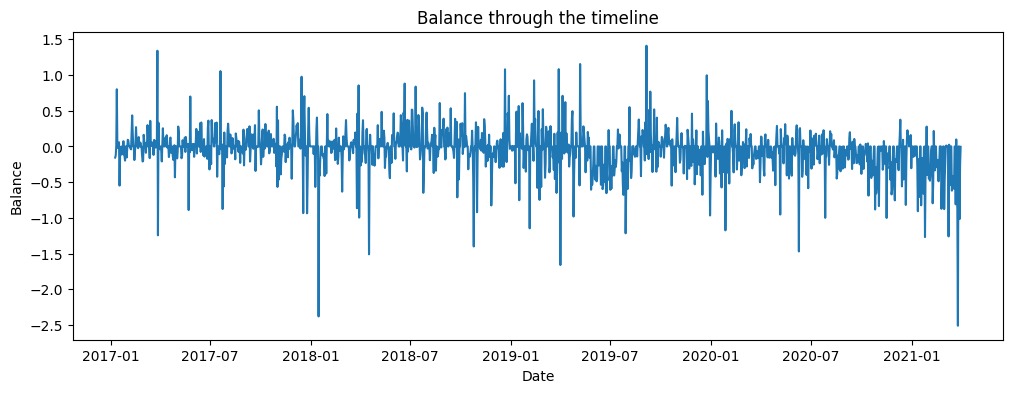

In [7]:
plot_time_series(df, x=df.index, y='Balance', title='Balance through the timeline', ylabel='Balance')

- В исходном временном ряде не наблюдается явной сезонности, тренда и цикла. В любом случае необходимо произвести анализ.
- Наблюдается аномальные значения, которые выбиваются из общего поведения. Также возможно наличие гетероскедастичности (неравномерность дисперсии вдоль времени).

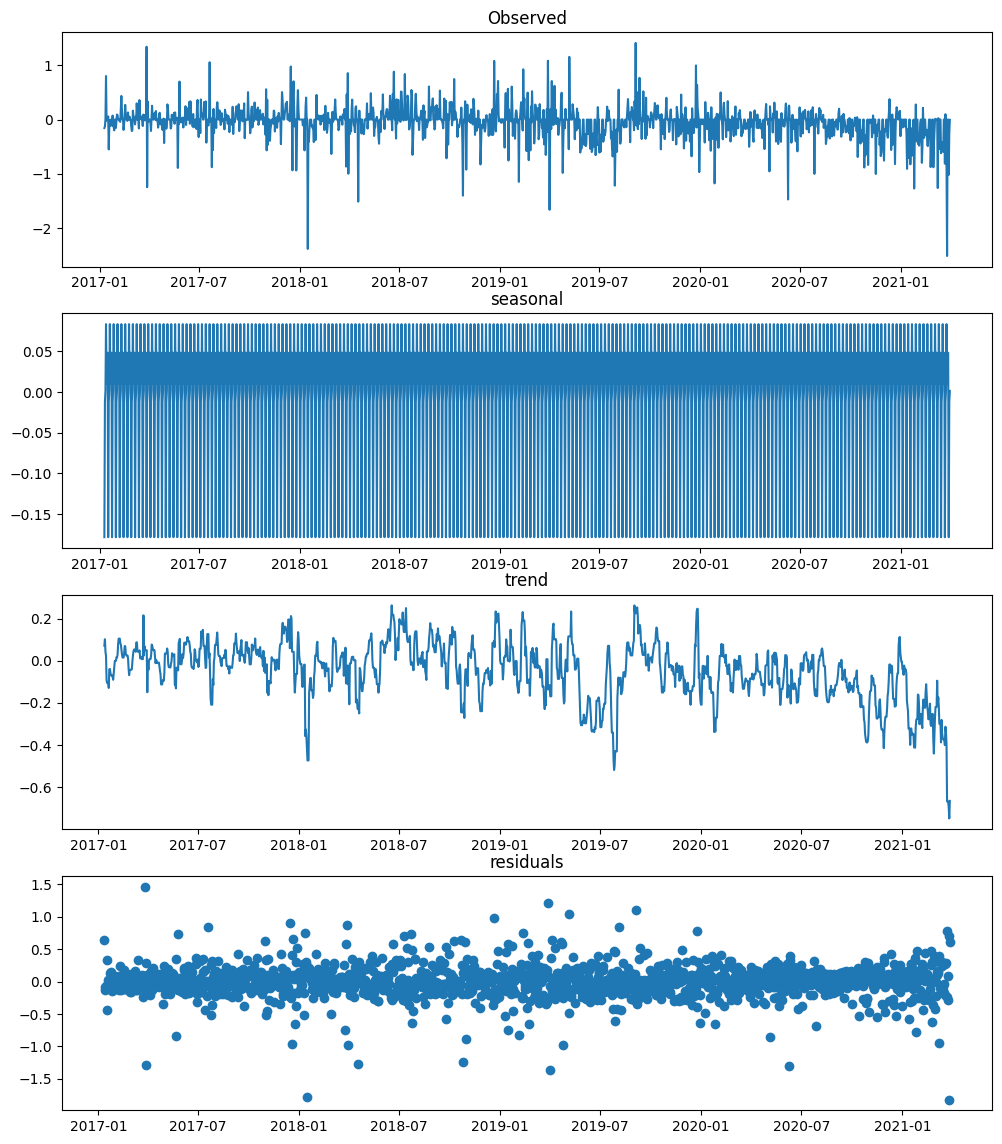

In [8]:
# Разложение ряда как суммы компонент базового значения, сезонности, тренда и случайного возмущения
additive_decomposition = seasonal_decompose(df['Balance'], model='additive')
plot_decomposition(additive_decomposition, df.index)

Декомпозиция:
- Аддитивная декомпозиция временного ряда не выявляет тренда, остатки не имеют явного поведения, но присутствуют единичные выбросы по значению остатков.
- Аддитивная декомпозиция временного ряда выявляет сезонность, похожую на недельную (каждые окно длиной 7 наблюдений), это плохо видно на графике выше, но при детализации на меньший масштаб графика и анализе на всей последовательности закономерность отчетливо прослеживается.
- Мультипликативная декомпозиция временного ряда неактуальна, так как ряд содержит отрицательные значения.

In [9]:
adfuller_result = adfuller(df['Balance'].values)
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

ADF Statistic: -4.115249325780113
p-value: 0.000913814018197207
Critial Values:
	1%, -3.4346537865963596
Critial Values:
	5%, -2.8634408535813285
Critial Values:
	10%, -2.5677819879092625


In [10]:
df['Balance_diff_7'] = df['Balance'] - df['Balance'].shift(7)
adfuller_result = adfuller(df['Balance_diff_7'].iloc[7:].values)
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

ADF Statistic: -13.87269327571695
p-value: 6.421458082728323e-26
Critial Values:
	1%, -3.4346737059247014
Critial Values:
	5%, -2.8634496449929934
Critial Values:
	10%, -2.567786669389711


- По критерию Дики-Фуллера гипотеза H0 о нестационарности исходного временного ряда отвергается.
- По критерию Дики-Фуллера гипотеза H0 о нестационарности продифференциированного(7) временного ряда отвергается.

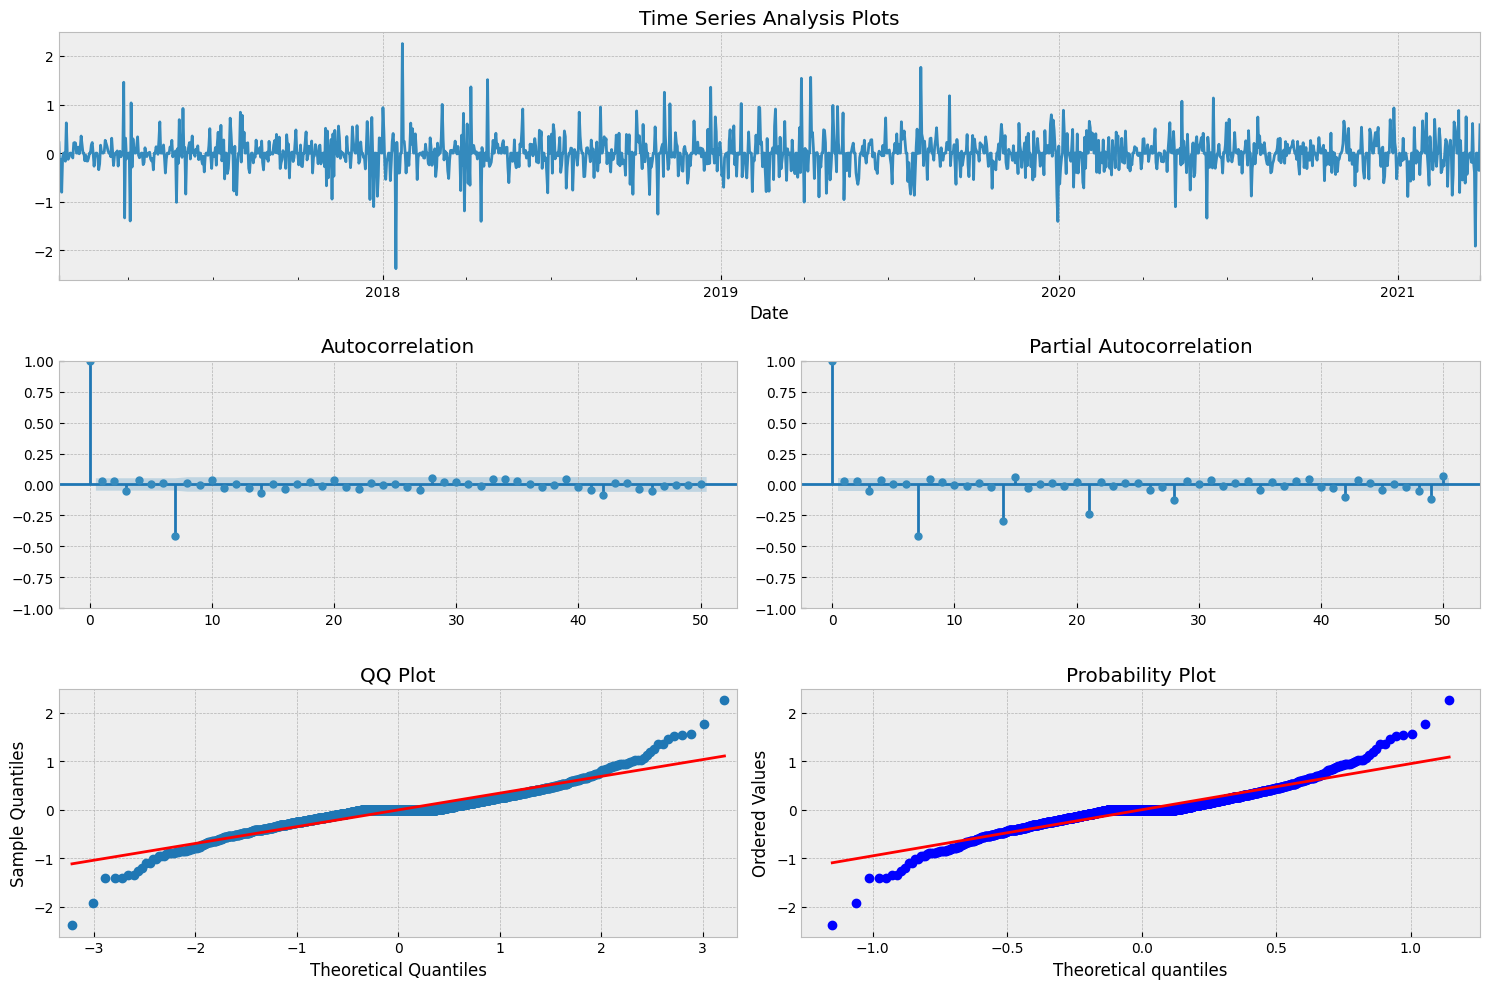

In [11]:
# Графики автокорреляции и частичной автокорреляции с максимальным лагом 50
tsplot(df['Balance_diff_7'][7:], 50)

Теорема Вольда утверждает, что любой стационарный временной ряд может быть описать моделью ARMA(p, q) с правильным подбором значений гиперпараметров p, q.

- ACF помогает задать приближение для q
- PACF помогает задать приближение для p

Начальные приближения:
- p = 7
- q = 7
- d = 1

В модели ARIMA необходимо будет задать параметры сезонности, так как присутствует недельная сезонность во временном ряде.